# This notebook contains the code for reproducing results for the following aims:


*   Aim 1: Psychopathology outcome random forest models and analysis



# Install

In [ ]:
!pip install shap
# !pip install lime
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=91333493a2a5bd620753d904d3ce34b9568d39166ef8619aaeae2506ed02f18b
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


# Import Libraries



Import some libraries

In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import io

# Utilities

Thesea are mostly helper functions to do miscellaneous data wrangling more easily. Run this whole block, since some of the functions are used later

In [ ]:
# missing values per column function
def show_missing_values(df):
    missing_counts = df.isnull().sum()
    missing_percentages = 100 * missing_counts / len(df)
    missing_table = pd.concat([missing_counts, missing_percentages], axis=1)
    missing_table = missing_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    missing_table = missing_table[missing_table.iloc[:, 0] != 0].sort_values('% of Total Values', ascending=False)
    return missing_table

In [ ]:
def find_no_missing_cols(df):
    no_missing_cols = df.columns[df.isnull().sum() == 0]
    return no_missing_cols

In [ ]:
def get_string_columns(df):
    string_cols = []
    for col in df.columns:
        if df[col].apply(lambda x: any([i.isalpha() for i in str(x)])).any():
            string_cols.append(col)
    return string_cols

In [ ]:
def convert_sex_to_binary(df, column_name):
    # create a new column with binary values
    df['binary_sex'] = df[column_name].apply(lambda x: 1 if x == 'M' else 0)
    return df

def convert_binary_to_sex(df, column_name):
    # create a new column with 'M' or 'F' values
    df['sex_from_binary'] = df[column_name].apply(lambda x: 'M' if x == 1 else 'F')
    return df

In [ ]:
# get rid of nan and all that undefined behavior
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=False)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(float)

In [ ]:
def select_all_except_first_row(df):
    return df.iloc[1:]

In [ ]:
# missing values per row
def count_nan_rows(df):
    total_rows = len(df)
    nan_rows = df.isnull().any(axis=1).sum()
    nan_percent = 100 * (nan_rows / total_rows)
    print("Number of rows with NaN values: {}".format(nan_rows))
    print("Percentage of rows with NaN values: {:.2f}%".format(nan_percent))
    return nan_rows, nan_percent

In [ ]:
def show_missing_rows(df):
    missing_counts = df.isnull().sum(axis=1)
    missing_percentages = 100 * missing_counts / len(df.columns)
    missing_table = pd.concat([missing_counts, missing_percentages], axis=1)
    missing_table = missing_table.rename(columns={0: 'Missing Values', 1: '% of Total Columns'})
    missing_table = missing_table[missing_table.iloc[:, 0] != 0].sort_values('% of Total Columns', ascending=False)
    return missing_table

In [ ]:
def count_value(df, value):
    count = (df == value).sum()
    count_table = pd.DataFrame({'Column': count.index, 'Count': count.values}).sort_values('Count', ascending=False)
    return count_table

In [ ]:
def remove_rows_with_value(df, value):
    new_df = df[~(df == value).any(axis=1)]
    return new_df

In [ ]:
def get_value_counts(df):
  # get unique values and counts for each column
  for column in df.columns:
      counts = df[column].value_counts()
      print(f"Counts for column '{column}':\n{counts}\n")

In [ ]:
def compute_stats_ed(df, col1, col2, col3):
    df['Avg Ed'] = df.apply(lambda x: (x[col1] + x[col2])/2 if x[col3] == 1 else x[col1], axis=1)
    df['Max Ed'] = df.apply(lambda x: max(x[col1], x[col2]) if x[col3] == 1 else x[col1], axis=1)
    df['Sum Ed'] = df.apply(lambda x: x[col1] if x[col3] != 1 else x[col1] + x[col2], axis=1)
    return df

In [ ]:
def check_number_in_columns(df, columns, number):
    for col in columns:
        if number in df[col].values:
            return True
    return False

In [ ]:
def sum_columns(df, column_list, new_column_name):
    df[new_column_name] = df[column_list].sum(axis=1)
    return df

In [ ]:
def distplots(df, bins=100):
  for i in range(1,len(df.columns)) :
      col_name = df.columns[i]  # get the column name to identify the graph
      x=df[col_name]
      plt.xlabel(col_name)         # The column name will be the x-label ( just to identify )
      k=plt.hist(x,bins)       # Change the right number of bins to get it more/less granular
      plt.show()

In [ ]:
def select_columns(df, condition_col, condition_func, cols_to_select):
    """
    Selects a list of columns from a Pandas dataframe based on whether a condition is satisfied in one of the columns.
    """
    # Filter the dataframe to only include rows where the condition is satisfied
    filtered_df = df[df[condition_col].apply(condition_func)]

    # Select the desired columns from the filtered dataframe
    selected_df = filtered_df[cols_to_select]

    return selected_df

In [ ]:
def check_value(df, value_cols, no_value_cols, value, new_col_name):
    # Check if value is present only in the specified value_cols
    mask_value = (df[value_cols] == value).all(axis=1)

    # Check if value is not present in any of the specified no_value_cols
    mask_no_value = (df[no_value_cols] != value).all(axis=1)

    # Create a new column with a 1 if both conditions are met, 0 otherwise
    df[new_col_name] = 0
    df.loc[mask_value & mask_no_value, new_col_name] = 1

    return df

In [ ]:
def convert_str_to_num(df):
    """
    Converts string representations of numbers in a dataframe to float data type.
    """
    for col in df.columns:
        if df[col].dtypes == object:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # if the column can't be converted, ignore it
    return df

In [ ]:
def convert_columns_to_float(df):
    """
    Converts all columns of a Pandas dataframe to be of type float, except for ones that contain alphabetic characters.
    """
    # Get a boolean mask indicating which columns contain alphabetic characters
    non_numeric_cols = df.select_dtypes(include=['object']).apply(lambda col: pd.to_numeric(col, errors='coerce').isna()).any()

    # Select only the numeric columns
    numeric_cols = df.select_dtypes(include=['float', 'int'])

    # Convert the numeric columns to float
    numeric_cols = numeric_cols.apply(pd.to_numeric, errors='coerce').astype('float')

    # Merge the numeric and non-numeric columns
    converted_df = pd.concat([numeric_cols, df.loc[:, non_numeric_cols]], axis=1)

    return converted_df

In [ ]:
def column_description_dict(df):
    # Get the first row of the dataframe
    first_row = df.iloc[0]

    # Create a dictionary with column names as keys and first row values as descriptions
    column_descriptions = {col: first_row[col] for col in df.columns}

    return column_descriptions

In [ ]:
def my_recode(x):
    if x == 1:
        return 1
    else:
        return 0

# Random forest models

## ML model and analysis dependencies

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

In [ ]:
import shap
import eli5
from eli5.sklearn import PermutationImportance

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
import itertools

## Model functions

In [ ]:
def run_single_model(X, y, cv, scoring):
    # Create a pipeline
    pipe = Pipeline([('preprocessing', StandardScaler()),
                     ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced', random_state=41))])

    scores = []
    for _ in range(cv.get_n_splits(X, y)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        score = {metric: score_func(y_test, y_pred) for metric, score_func in scoring.items()}
        scores.append(score)

        model = pipe.named_steps['classifier']

    return scores, pipe, model


# Scoring dictionary
scoring = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    'auc': lambda y_true, y_pred: roc_auc_score(y_true, y_pred, average='weighted'),
    'confusion_matrix': lambda y_true, y_pred: confusion_matrix(y_true, y_pred),
    'roc_curve': lambda y_true, y_pred: roc_curve(y_true, y_pred),
    'precision_recall_curve': lambda y_true, y_pred: precision_recall_curve(y_true, y_pred)
}

In [ ]:
# Create an instance of StratifiedKFold
strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
def extract_instances(dataset, num_instances):
    # Check if the number of instances requested is greater than the dataset size
    if num_instances > len(dataset):
        raise ValueError("Number of instances requested is greater than dataset size.")

    # Resample the dataset to extract the desired number of instances
    extracted_instances = resample(dataset, n_samples=num_instances, replace=False)

    return extracted_instances

In [ ]:
def calculate_permutation_importance(model, X, y, scoring_metric):
    perm_importance = PermutationImportance(model, scoring=scoring_metric, random_state=42)
    perm_importance.fit(X, y)
    feature_importances = perm_importance.feature_importances_
    feature_names = X.columns

    sorted_indices = np.argsort(feature_importances)
    sorted_importances = feature_importances[sorted_indices][::-1]
    sorted_names = feature_names[sorted_indices][::-1]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_names)
    plt.xlabel('Permutation Importance')
    plt.ylabel('Features')
    plt.title('Permutation Importance of Features')
    plt.show()

## Plotting functions

In [ ]:
def plot_evaluation(pipe, X, y):
    # Calculate and display evaluation metrics
    y_pred = pipe.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Confusion Matrix
    im = axes[0, 0].imshow(cm, cmap='Blues', aspect='auto')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('True')
    axes[0, 0].set_title('Confusion Matrix')

    # Add numbers to the confusion matrix cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0, 0].text(j, i, cm[i, j], ha='center', va='center', color='black')

    # Colorbar for the confusion matrix
    cbar = axes[0, 0].figure.colorbar(im, ax=axes[0, 0])
    cbar.ax.set_ylabel('Counts', rotation=90, va='bottom')

    # ROC Curve
    axes[0, 1].plot(fpr, tpr)
    axes[0, 1].plot([0, 1], [0, 1], 'k--')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')

    # Precision-Recall Curve
    axes[1, 0].plot(recall, precision)
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')

    # Feature Importances
    importances = pipe.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]  # Reverse order

    axes[1, 1].barh(range(len(indices)), importances[indices], color='b', align='center')
    axes[1, 1].set_yticks(range(len(indices)))
    axes[1, 1].set_yticklabels([X.columns[i] for i in indices])
    axes[1, 1].set_xlabel('Relative Importance')
    axes[1, 1].set_title('Feature Importances')
    axes[1, 1].invert_yaxis()

    # # Display evaluation metrics
    # table_data = [['Accuracy', accuracy],
    #               ['Precision', precision],
    #               ['Recall', recall],
    #               ['F1-Score', f1],
    #               ['AUC', auc]]

    # # Select the top value for each metric
    # table_data = [[metric, score] for metric, score in table_data]

    # table = axes[1, 0].table(cellText=table_data, colWidths=[0.3, 0.2], loc='center')
    # table.auto_set_font_size(False)
    # table.set_fontsize(10)

    # Adjust plot layout
    plt.tight_layout()
    plt.show()

In [ ]:
def generate_metrics_table(scores):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    metrics_table = pd.DataFrame(columns=['Metric', 'Score'])

    for metric in metrics:
        scores_for_metric = [score[metric] for score in scores]
        max_score = np.max(scores_for_metric)

        metrics_table = metrics_table.append({'Metric': metric.capitalize(), 'Score': max_score}, ignore_index=True)

    return metrics_table

## Psychopathology outcomes (Aim 1)

### Psychopathology

Total problems

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

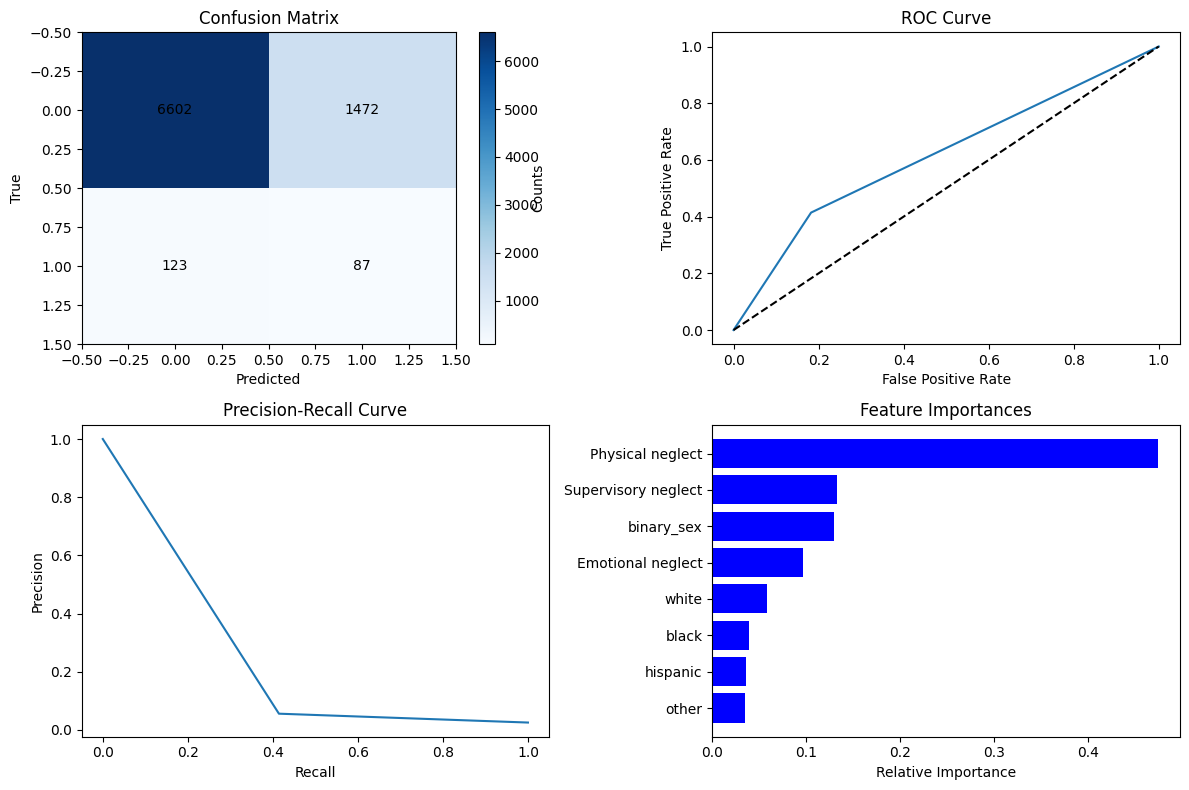

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.807483
1,Precision,0.954865
2,Recall,0.807483
3,F1,0.871843
4,Auc,0.564979


In [ ]:
# Run single model
scores_tb, pipe_tb, model_tb = run_single_model(X_neg, y_tb, strat_k_fold, scoring)

plot_evaluation(pipe_tb, X_neg, y_tb)

generate_metrics_table(scores_tb)

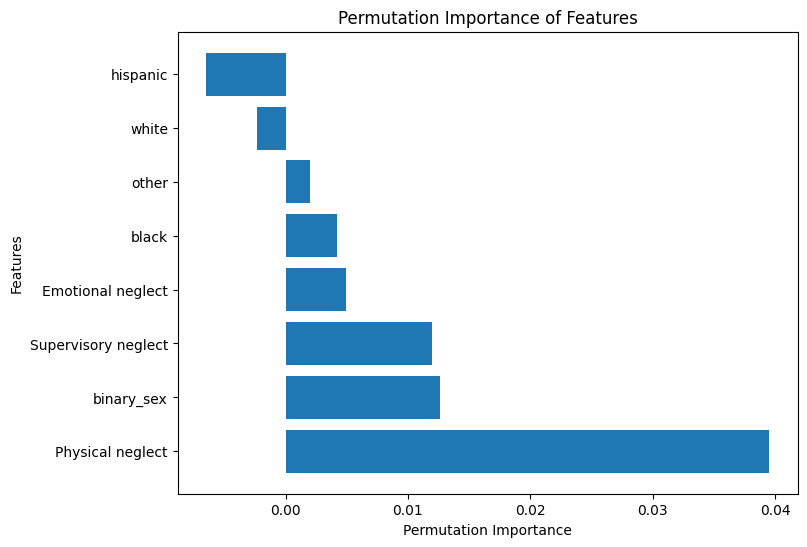

In [ ]:
calculate_permutation_importance(pipe_tb, X_neg, y_tb, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

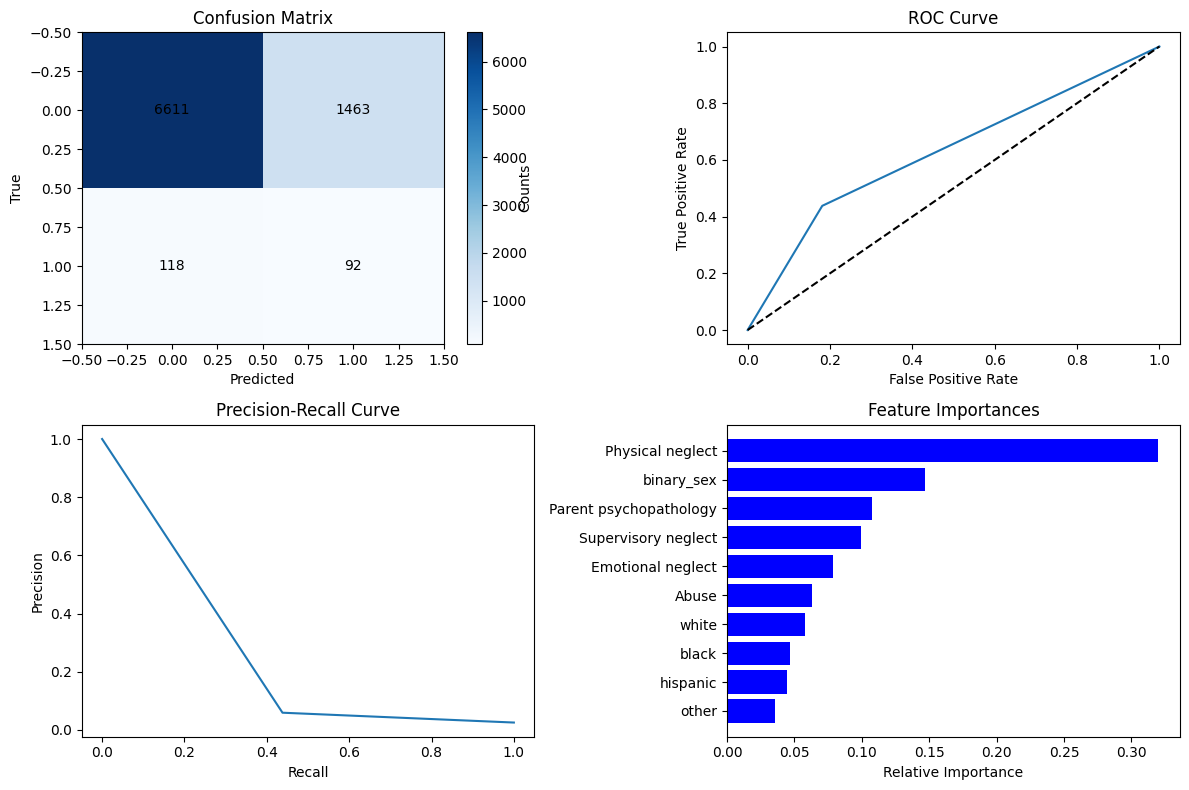

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.805069
1,Precision,0.954789
2,Recall,0.805069
3,F1,0.870365
4,Auc,0.563740


In [ ]:
# Run single model
scores_tb, pipe_tb, model_tb = run_single_model(X_neg_2, y_tb, strat_k_fold, scoring)

plot_evaluation(pipe_tb, X_neg_2, y_tb)

generate_metrics_table(scores_tb)

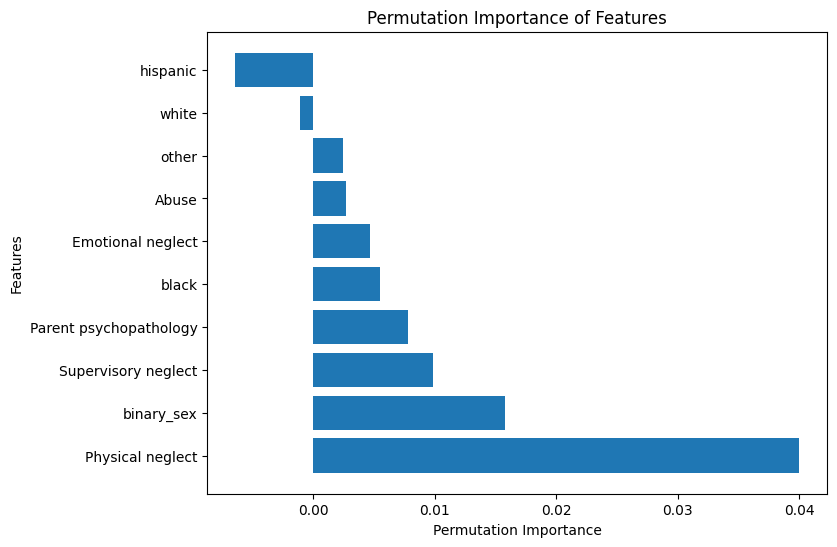

In [ ]:
calculate_permutation_importance(pipe_tb, X_neg_2, y_tb, 'f1')

Internalizing

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

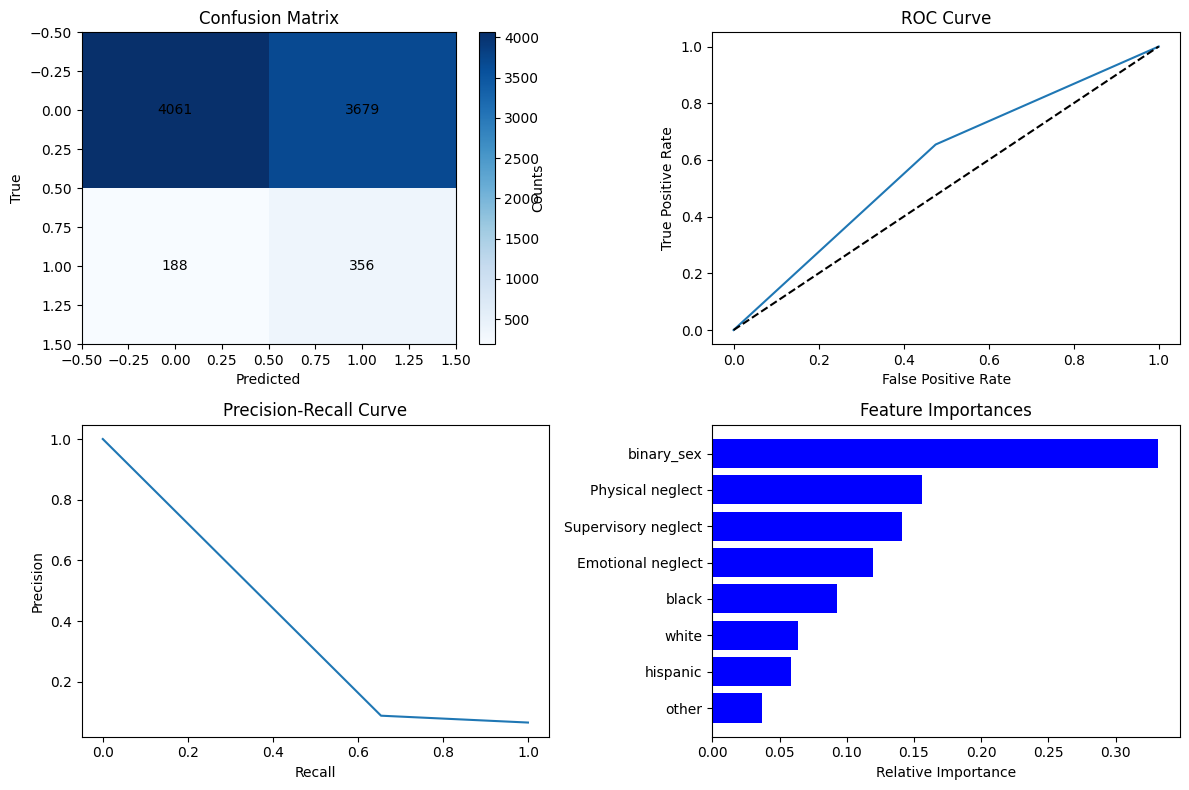

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.527459
1,Precision,0.897730
2,Recall,0.527459
3,F1,0.638125
4,Auc,0.585055


In [ ]:
# Run single model
scores_ib, pipe_ib, model_ib = run_single_model(X_neg, y_ib, strat_k_fold, scoring)

plot_evaluation(pipe_ib, X_neg, y_ib)

generate_metrics_table(scores_ib)

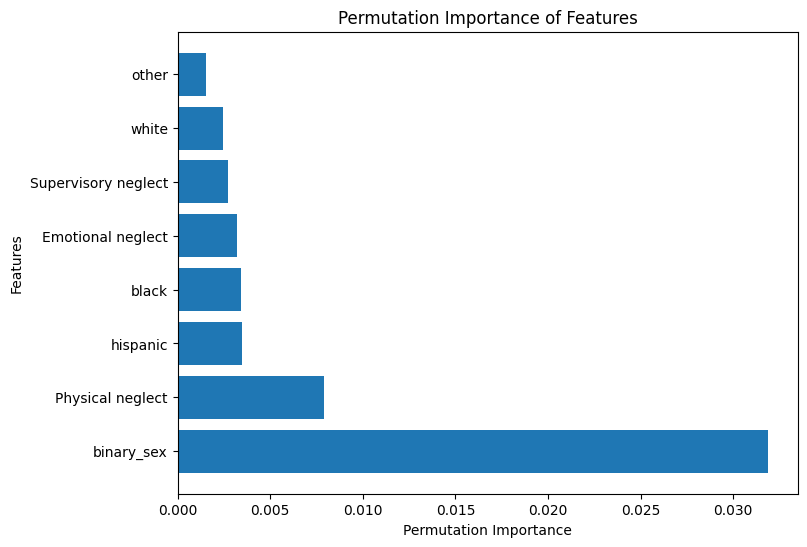

In [ ]:
calculate_permutation_importance(pipe_ib, X_neg, y_ib, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

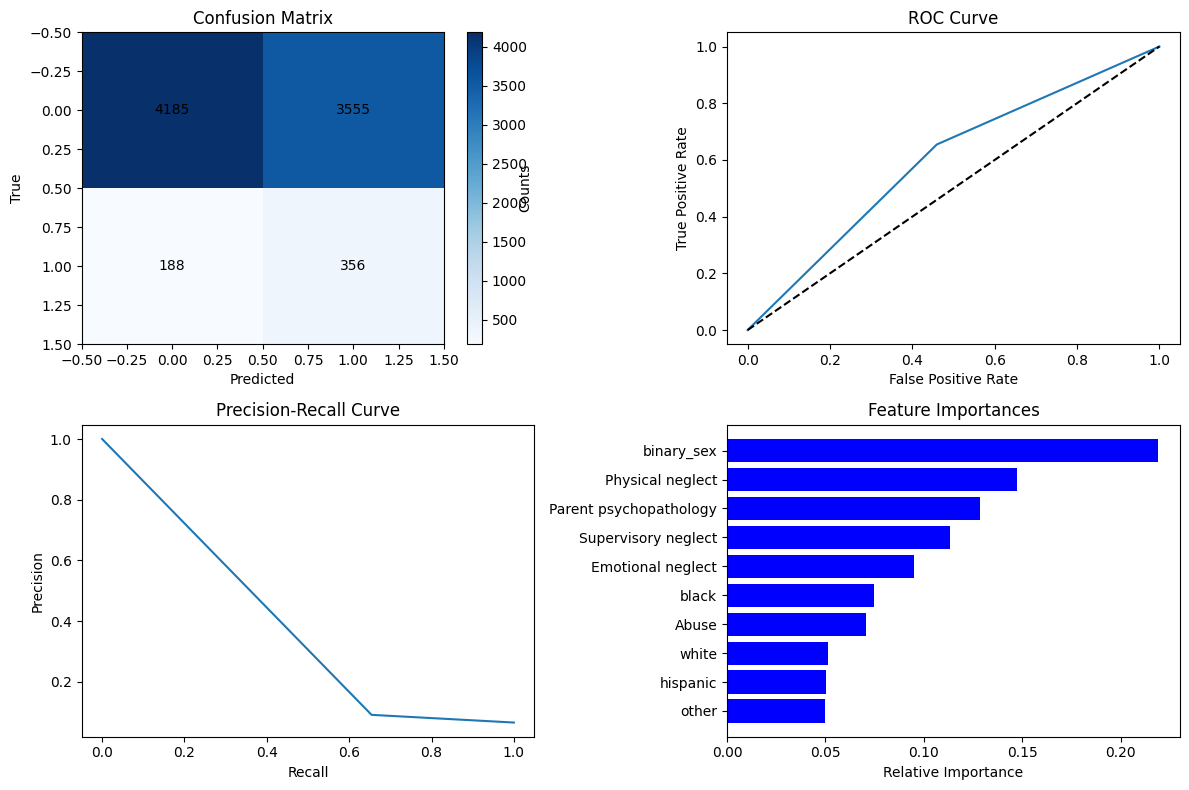

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.537719
1,Precision,0.896577
2,Recall,0.537719
3,F1,0.647326
4,Auc,0.582018


In [ ]:
# Run single model
scores_ib, pipe_ib, model_ib = run_single_model(X_neg_2, y_ib, strat_k_fold, scoring)

plot_evaluation(pipe_ib, X_neg_2, y_ib)

generate_metrics_table(scores_ib)

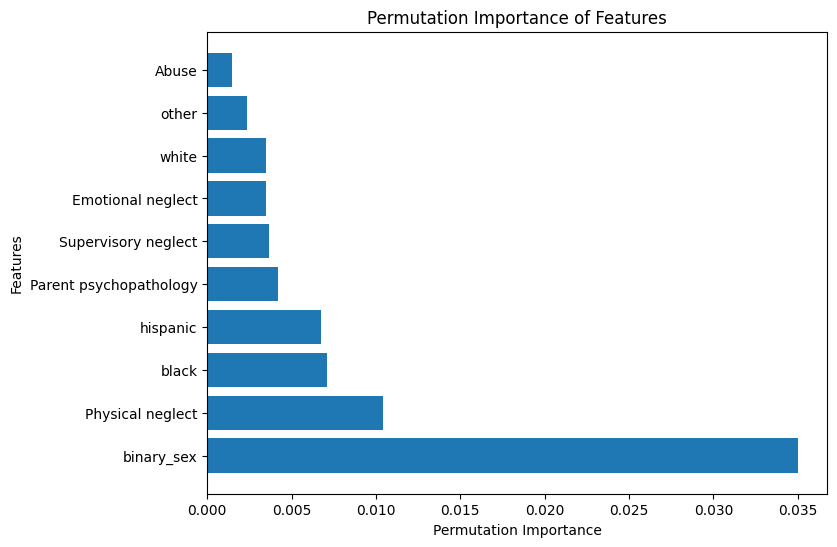

In [ ]:
calculate_permutation_importance(pipe_ib, X_neg_2, y_ib, 'f1')

Externalizing

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

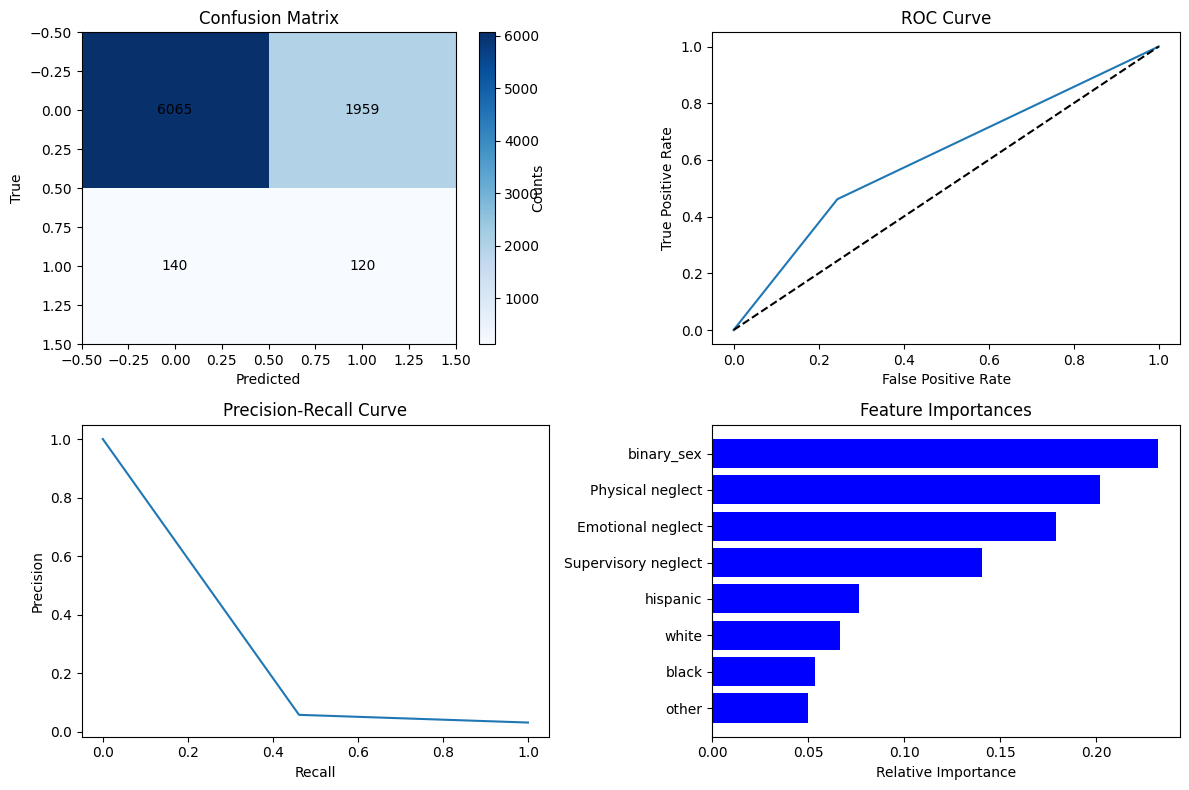

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.741098
1,Precision,0.943512
2,Recall,0.741098
3,F1,0.825194
4,Auc,0.550024


In [ ]:
# Run single model
scores_eb, pipe_eb, model_eb = run_single_model(X_neg, y_eb, strat_k_fold, scoring)

plot_evaluation(pipe_eb, X_neg, y_eb)

generate_metrics_table(scores_eb)

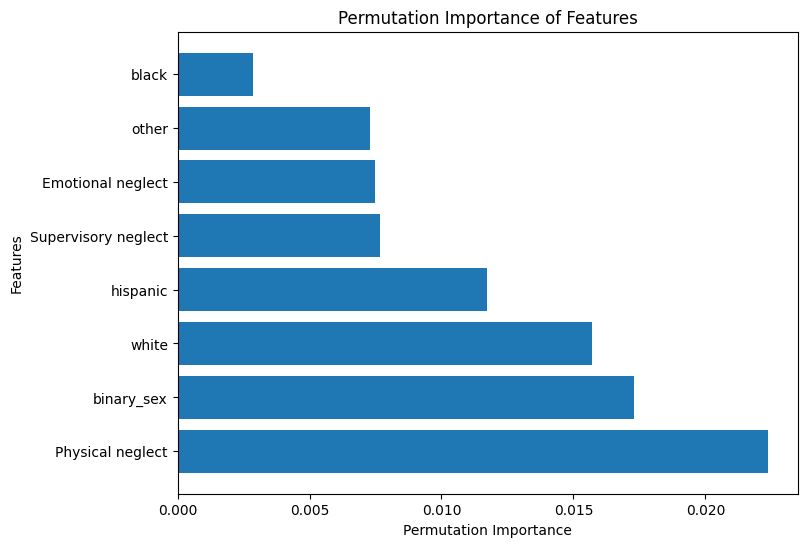

In [ ]:
calculate_permutation_importance(pipe_eb, X_neg, y_eb, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

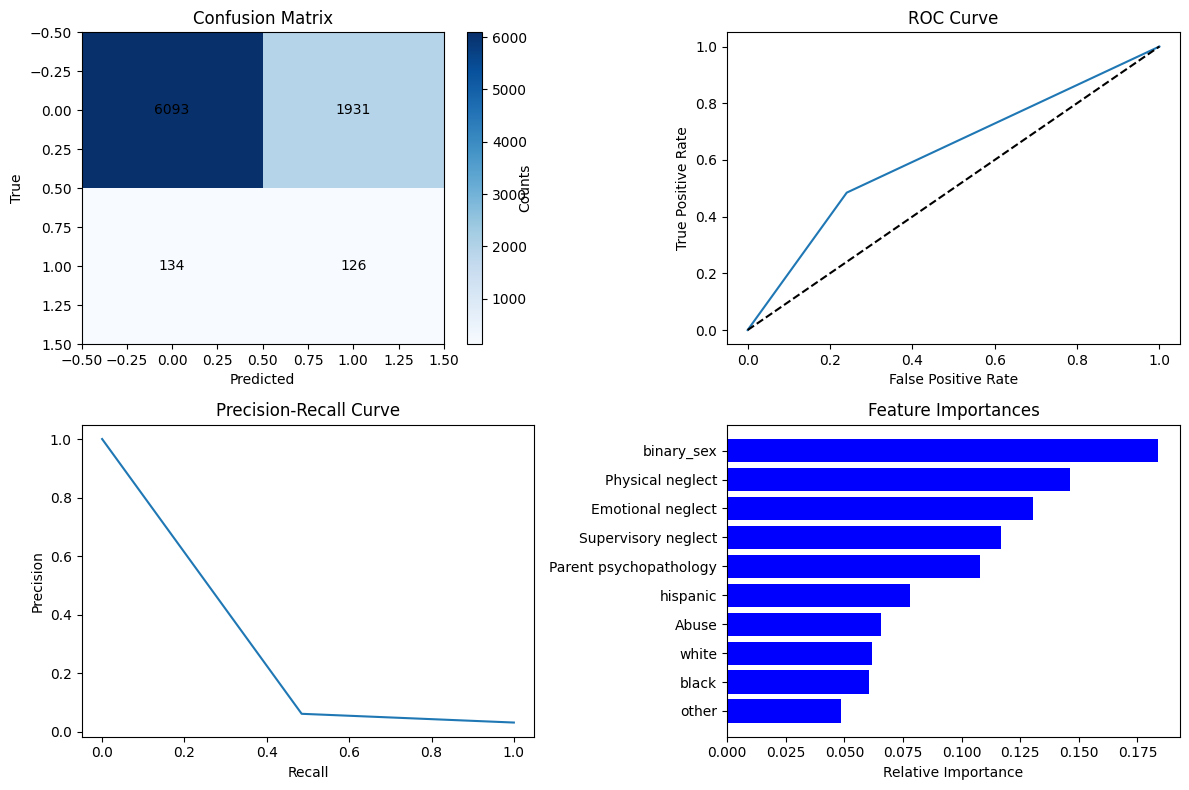

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.744116
1,Precision,0.944439
2,Recall,0.744116
3,F1,0.827197
4,Auc,0.560885


In [ ]:
# Run single model
scores_eb, pipe_eb, model_eb = run_single_model(X_neg_2, y_eb, strat_k_fold, scoring)

plot_evaluation(pipe_eb, X_neg_2, y_eb)

generate_metrics_table(scores_eb)

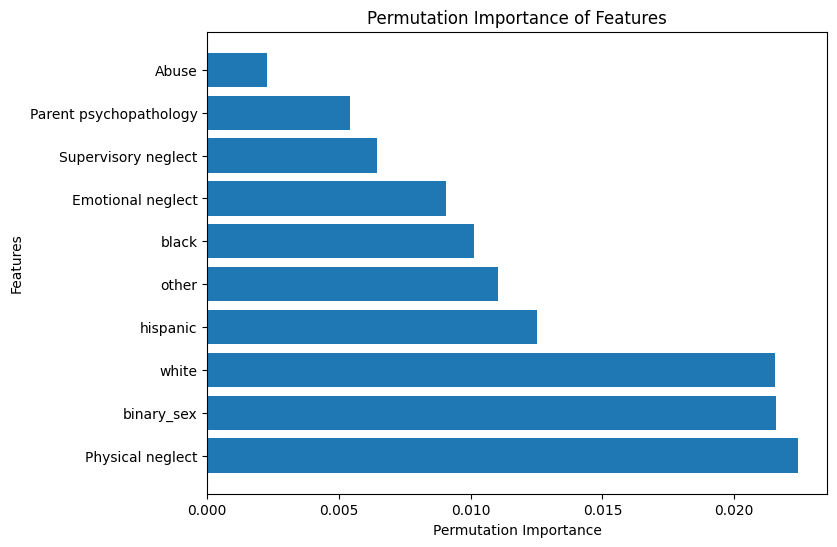

In [ ]:
calculate_permutation_importance(pipe_eb, X_neg_2, y_eb, 'f1')

### STBs

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

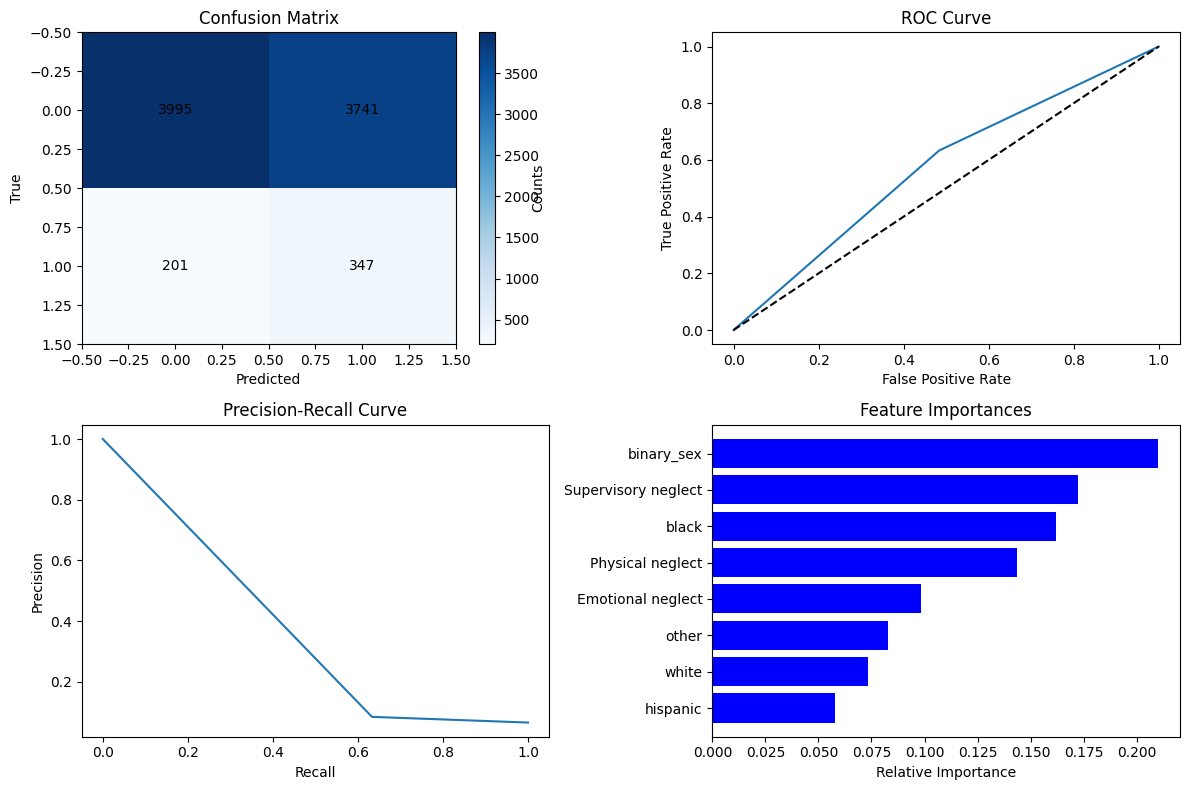

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.506940
1,Precision,0.888618
2,Recall,0.506940
3,F1,0.620327
4,Auc,0.550162


In [ ]:
# Run single model
scores_stb, pipe_stb, model_stb = run_single_model(X_neg, y_stb, strat_k_fold, scoring)

plot_evaluation(pipe_stb, X_neg, y_stb)

generate_metrics_table(scores_stb)

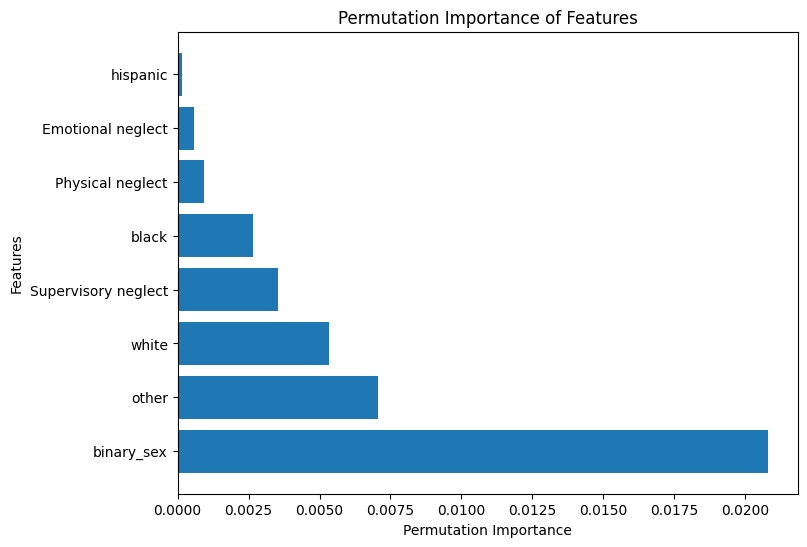

In [ ]:
calculate_permutation_importance(pipe_stb, X_neg, y_stb, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

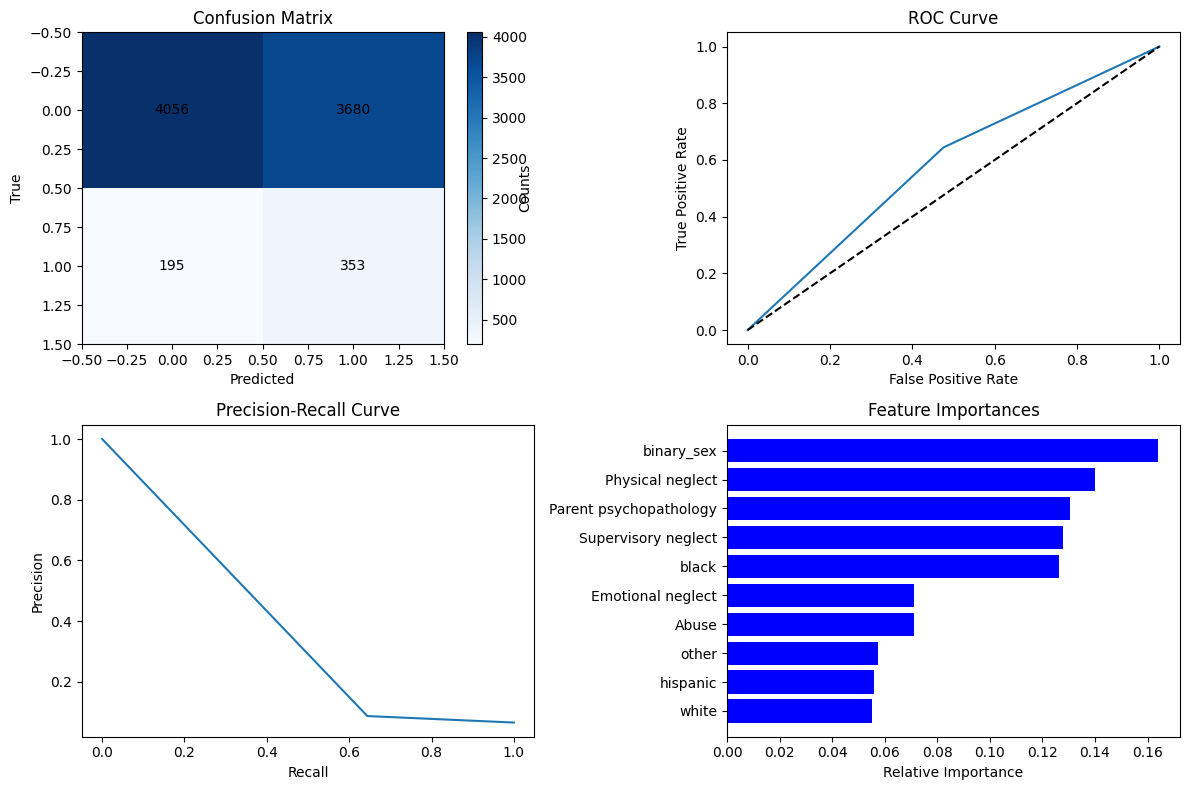

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.516596
1,Precision,0.889683
2,Recall,0.516596
3,F1,0.628927
4,Auc,0.555333


In [ ]:
# Run single model
scores_stb, pipe_stb, model_stb = run_single_model(X_neg_2, y_stb, strat_k_fold, scoring)

plot_evaluation(pipe_stb, X_neg_2, y_stb)

generate_metrics_table(scores_stb)

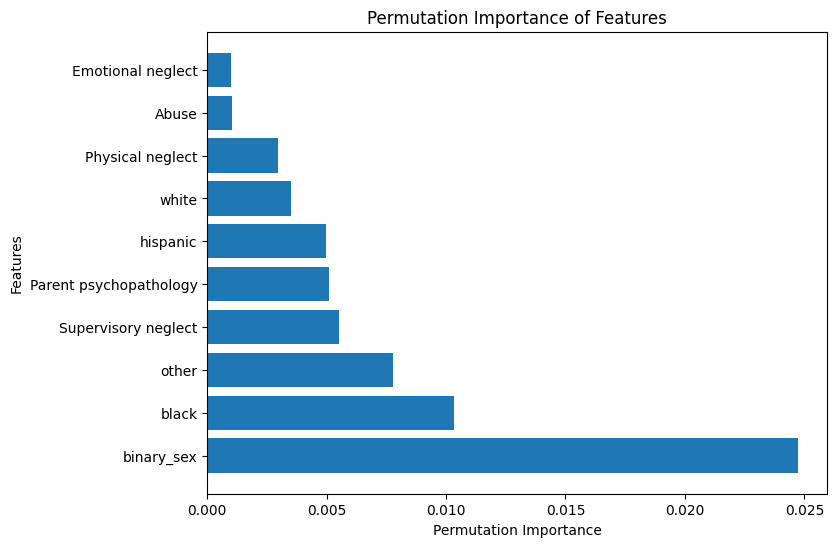

In [ ]:
calculate_permutation_importance(pipe_stb, X_neg_2, y_stb, 'f1')

## Secondary prediction

These models include total problems as a predictor

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

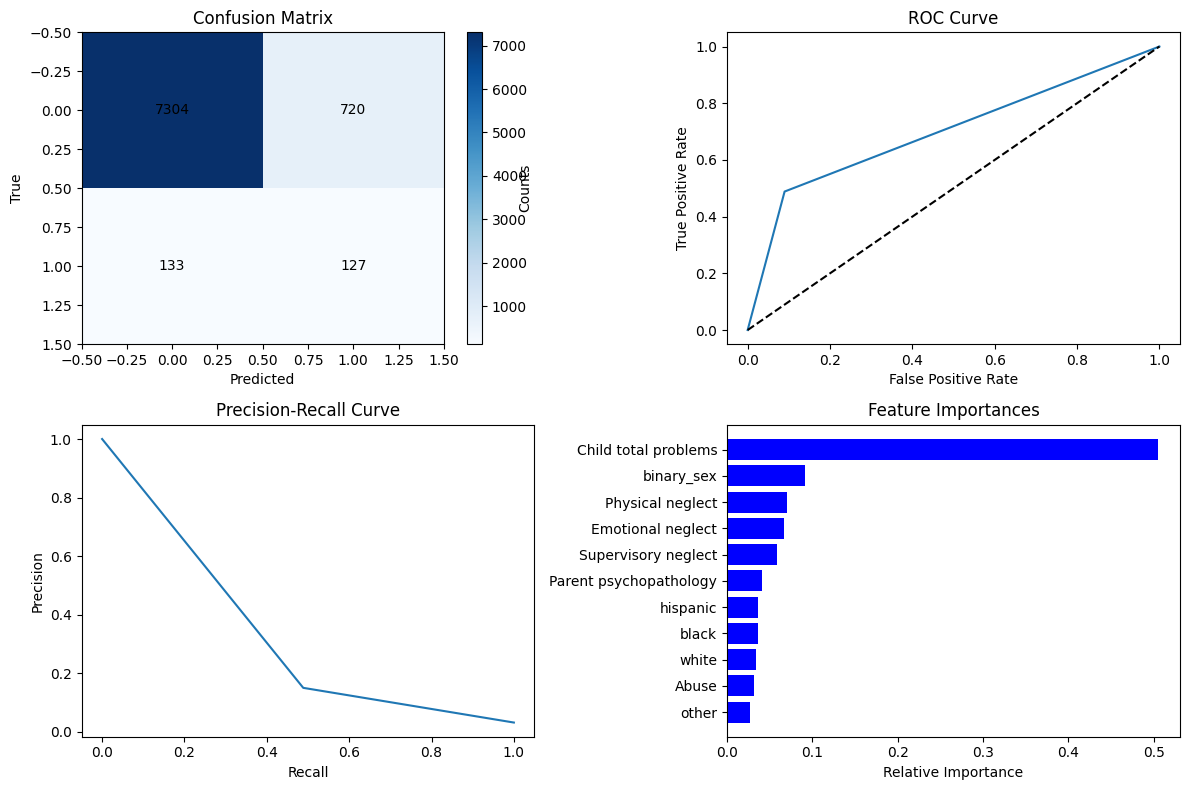

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.901629
1,Precision,0.953726
2,Recall,0.901629
3,F1,0.924473
4,Auc,0.670105


In [ ]:
# Run single model
scores_tbeb, pipe_tbeb, model_tbeb = run_single_model(X_neg_3, y_eb, strat_k_fold, scoring)

plot_evaluation(pipe_tbeb, X_neg_3, y_eb)

generate_metrics_table(scores_tbeb)

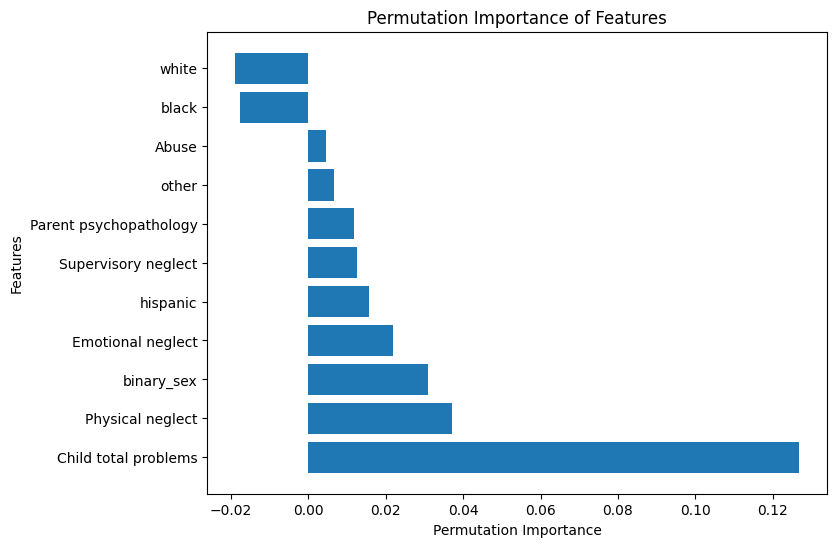

In [ ]:
calculate_permutation_importance(pipe_tbeb, X_neg_3, y_eb, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

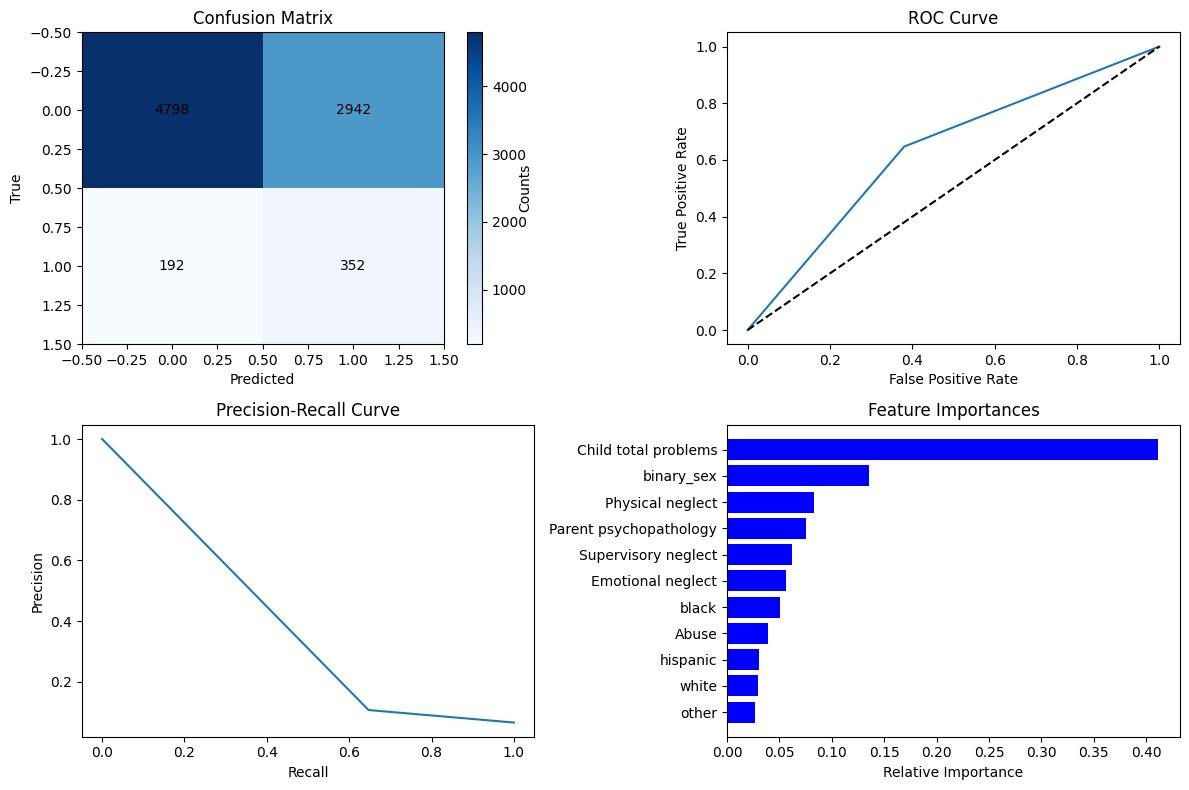

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.606518
1,Precision,0.903553
2,Recall,0.606518
3,F1,0.704328
4,Auc,0.623104


In [ ]:
# Run single model
scores_tbib, pipe_tbib, model_tbib = run_single_model(X_neg_3, y_ib, strat_k_fold, scoring)

plot_evaluation(pipe_tbib, X_neg_3, y_ib)

generate_metrics_table(scores_tbib)

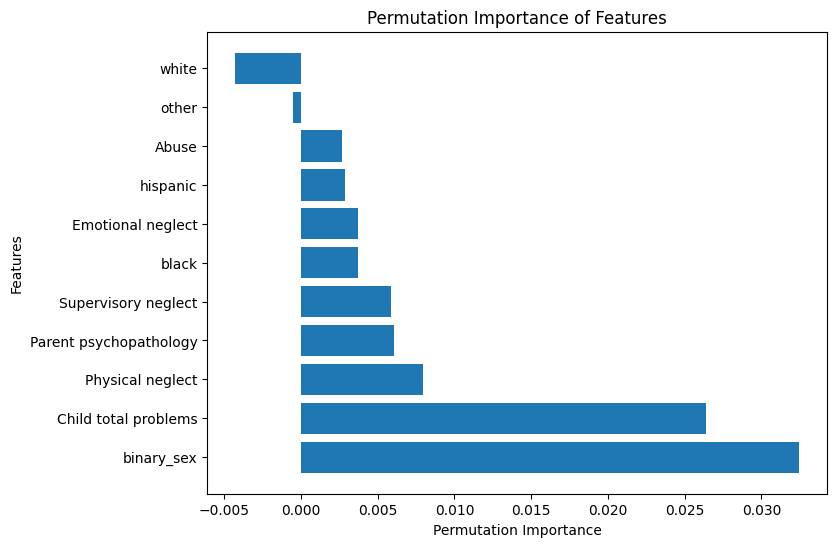

In [ ]:
calculate_permutation_importance(pipe_tbib, X_neg_3, y_ib, 'f1')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

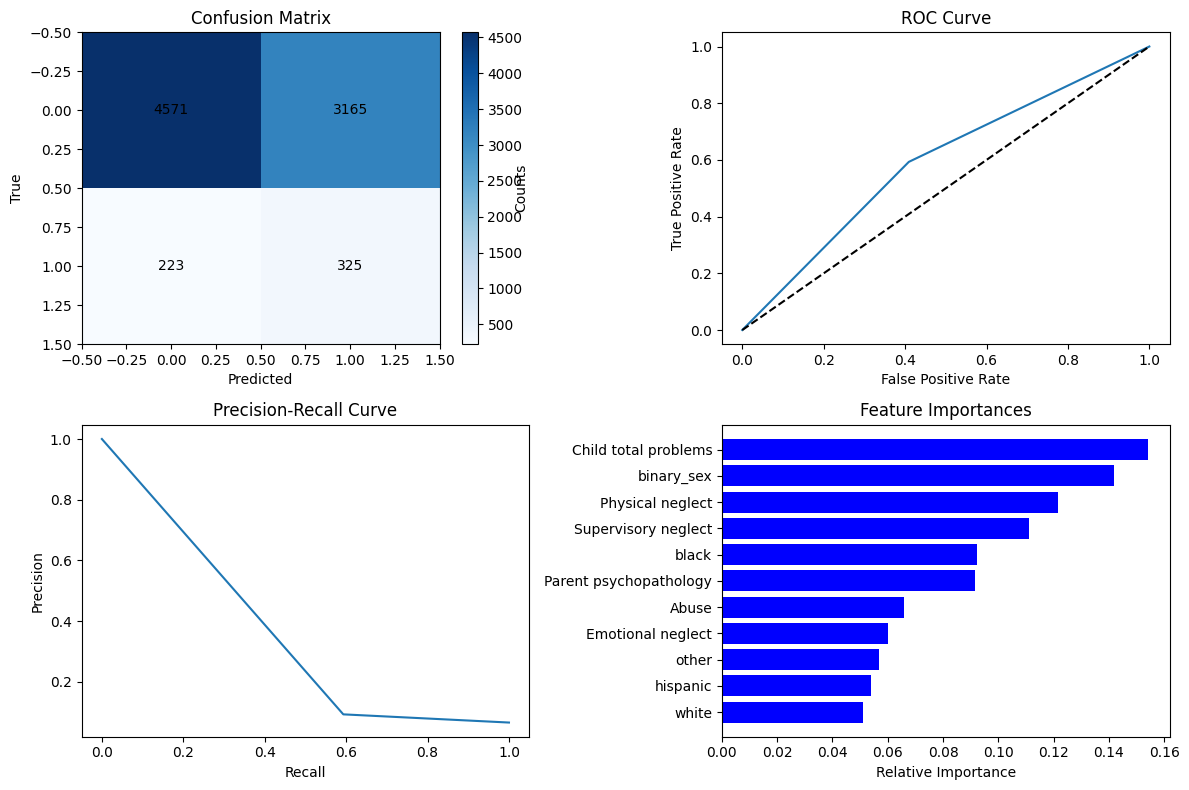

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Metric,Score
0,Accuracy,0.576946
1,Precision,0.888913
2,Recall,0.576946
3,F1,0.680869
4,Auc,0.558098


In [ ]:
# Run single model
scores_tbstb, pipe_tbstb, model_tbstb = run_single_model(X_neg_3, y_stb, strat_k_fold, scoring)

plot_evaluation(pipe_tbstb, X_neg_3, y_stb)

generate_metrics_table(scores_tbstb)

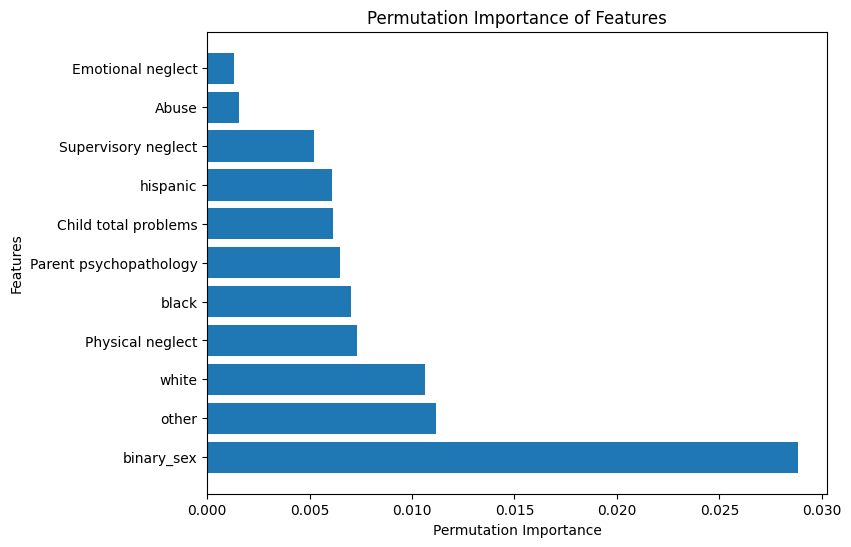

In [ ]:
calculate_permutation_importance(pipe_tbstb, X_neg_3, y_stb, 'f1')